In [1]:
from backend.src.extractors.data_ingestion import DataIngestion
from backend.src.extractors.image_summarizer import ImageSummarizer
from backend.src.extractors.text_summarizer import TextSummarizer
from backend.src.constants import *
from backend.src.config.configuration import ConfigurationManager
import os

from langchain_openai import ChatOpenAI

/Users/goldyrana/miniconda3/envs/bounce/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/goldyrana/mess/deep_learning/projects/rag/backend/notebooks


In [2]:
os.getcwd()

'/Users/goldyrana/mess/deep_learning/projects/rag/backend/notebooks'

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
os.chdir('../../') 
os.getcwd()

'/Users/goldyrana/mess/deep_learning/projects/rag'

In [5]:
test_pdf_path = "data/raw_pdfs/2023_removed.pdf"
model = ChatOpenAI(temperature=0, model="gpt-4o")

config_manager = ConfigurationManager(CONFIG_FILE_PATH, PARAMS_FILE_PATH)
data_ingestion_config = config_manager.get_data_ingestion_params()
image_summarizer_config = config_manager.get_image_summarizer_params()
text_summarizer_config = config_manager.get_text_summarizer_params()

data_ingestion = DataIngestion(data_ingestion_config)
image_summarizer = ImageSummarizer(image_summarizer_config, model)

2025-02-11 18:54:26,880 - root - INFO - Yaml read successfully from config.yaml
2025-02-11 18:54:26,881 - root - INFO - Yaml read successfully from params.yaml
2025-02-11 18:54:26,883 - root - ERROR - Exception occured while reading yaml file from                         location: params.yaml
 First argument must be mapping or iterable
2025-02-11 18:54:26,884 - root - INFO - Json object read sucessfully 
2025-02-11 18:54:26,884 - root - INFO - Json object read sucessfully 


2025-02-11 18:44:25,390 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): api.smith.langchain.com:443
2025-02-11 18:44:25,459 - openai._base_client - DEBUG - Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'content': [{'type': 'text', 'text': 'Describe the image in detail. Be specific about graphs and numbers'}, {'type': 'image_url', 'image_url': {'url': ''}}], 'role': 'user'}], 'model': 'gpt-4o', 'stream': False, 'temperature': 0.0}}
2025-02-11 18:44:25,463 - openai._base_client - DEBUG - Sending HTTP Request: POST https://api.openai.com/v1/chat/completions
2025-02-11 18:44:25,464 - httpcore.connection - DEBUG - connect_tcp.started host='api.openai.com' port=443 local_address=None timeout=None socket_options=None
2025-02-11 18:44:25,540 - httpcore.connection - DEBUG - connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x357fd9c70>
2025-02-11 18:44:25,541 - httpcore.connection - 
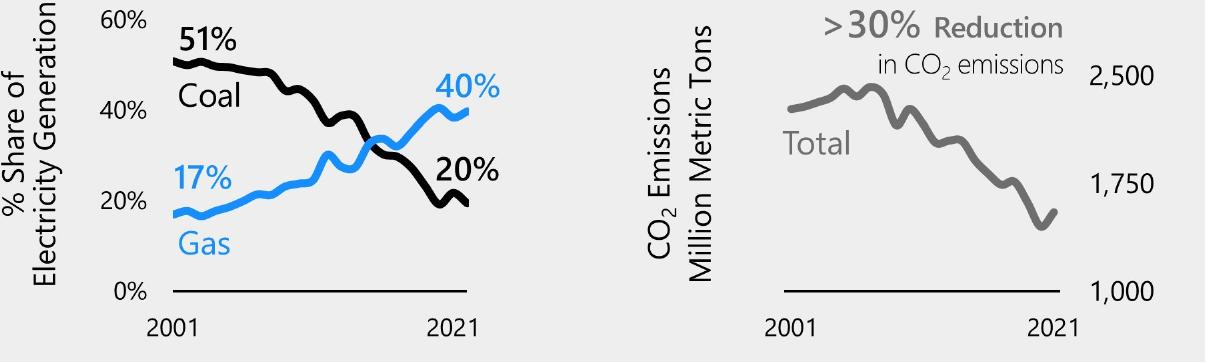

backend/data/reports/2023_removed/images


2025-02-11 18:44:25,560 - httpcore.connection - DEBUG - start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0x329e357c0>
2025-02-11 18:44:25,561 - httpcore.http11 - DEBUG - send_request_headers.started request=<Request [b'POST']>
2025-02-11 18:44:25,562 - httpcore.http11 - DEBUG - send_request_headers.complete
2025-02-11 18:44:25,562 - httpcore.http11 - DEBUG - send_request_body.started request=<Request [b'POST']>
2025-02-11 18:44:25,563 - httpcore.http11 - DEBUG - send_request_body.complete
2025-02-11 18:44:25,564 - httpcore.http11 - DEBUG - receive_response_headers.started request=<Request [b'POST']>
2025-02-11 18:44:25,738 - urllib3.connectionpool - DEBUG - https://api.smith.langchain.com:443 "GET /info HTTP/1.1" 200 672
2025-02-11 18:44:26,318 - urllib3.connectionpool - DEBUG - https://api.smith.langchain.com:443 "POST /runs/multipart HTTP/1.1" 202 34
2025-02-11 18:44:33,591 - httpcore.http11 - DEBUG - receive_response_headers.complete return_value=(b'HTTP
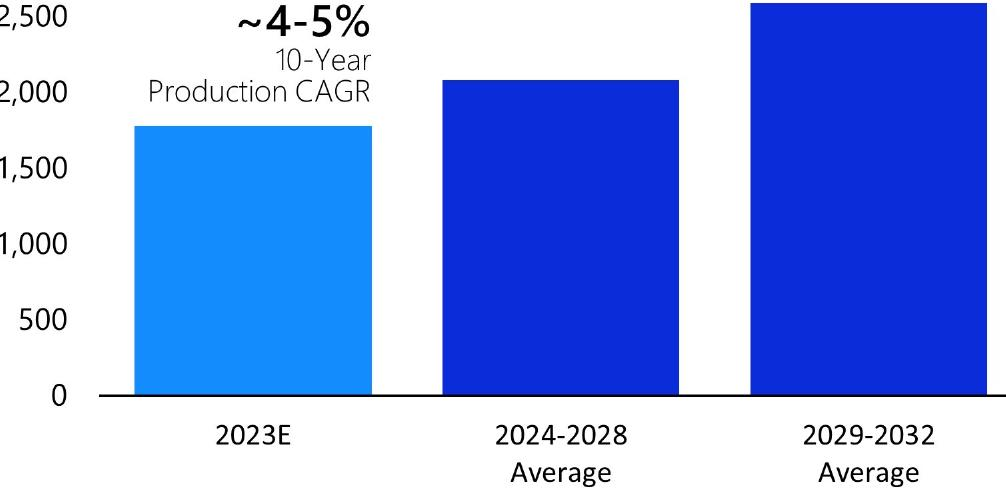
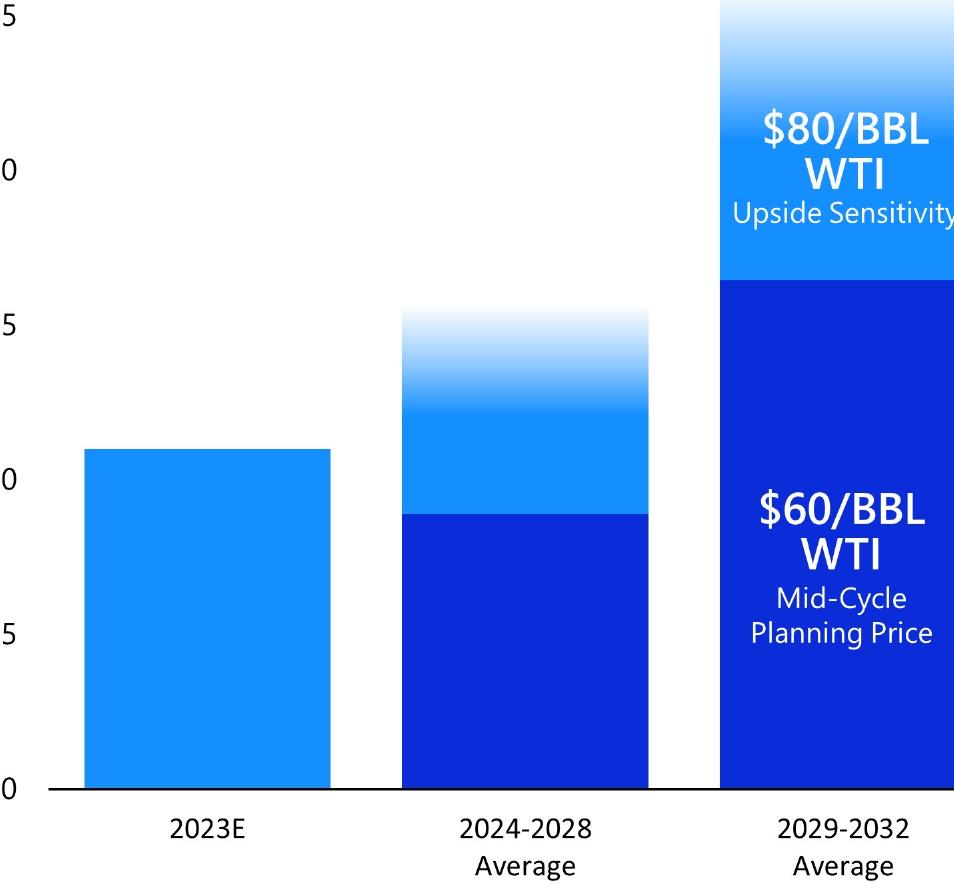
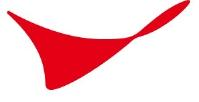
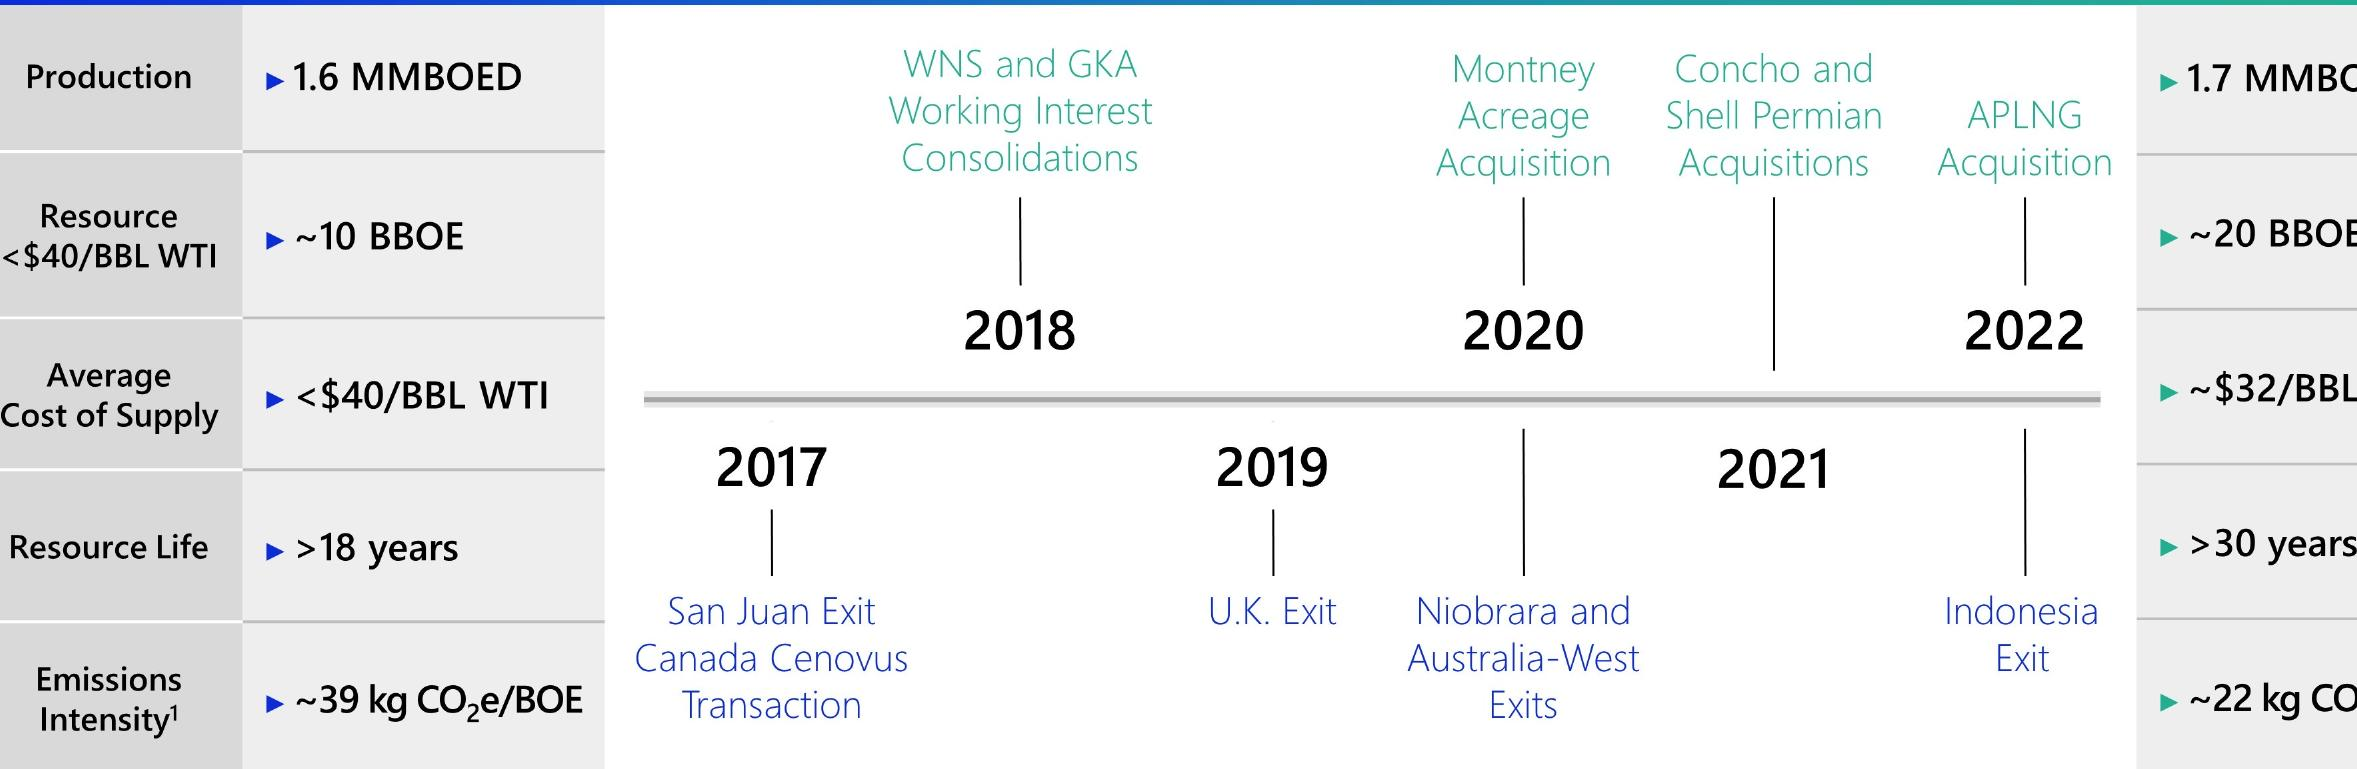
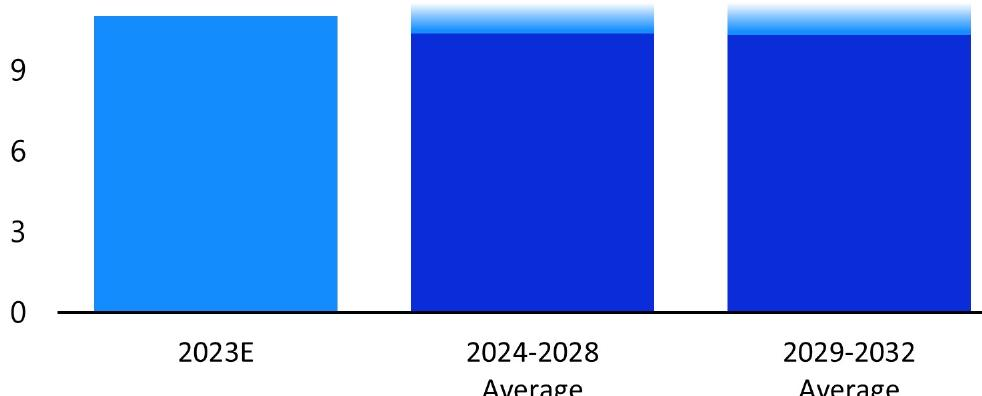
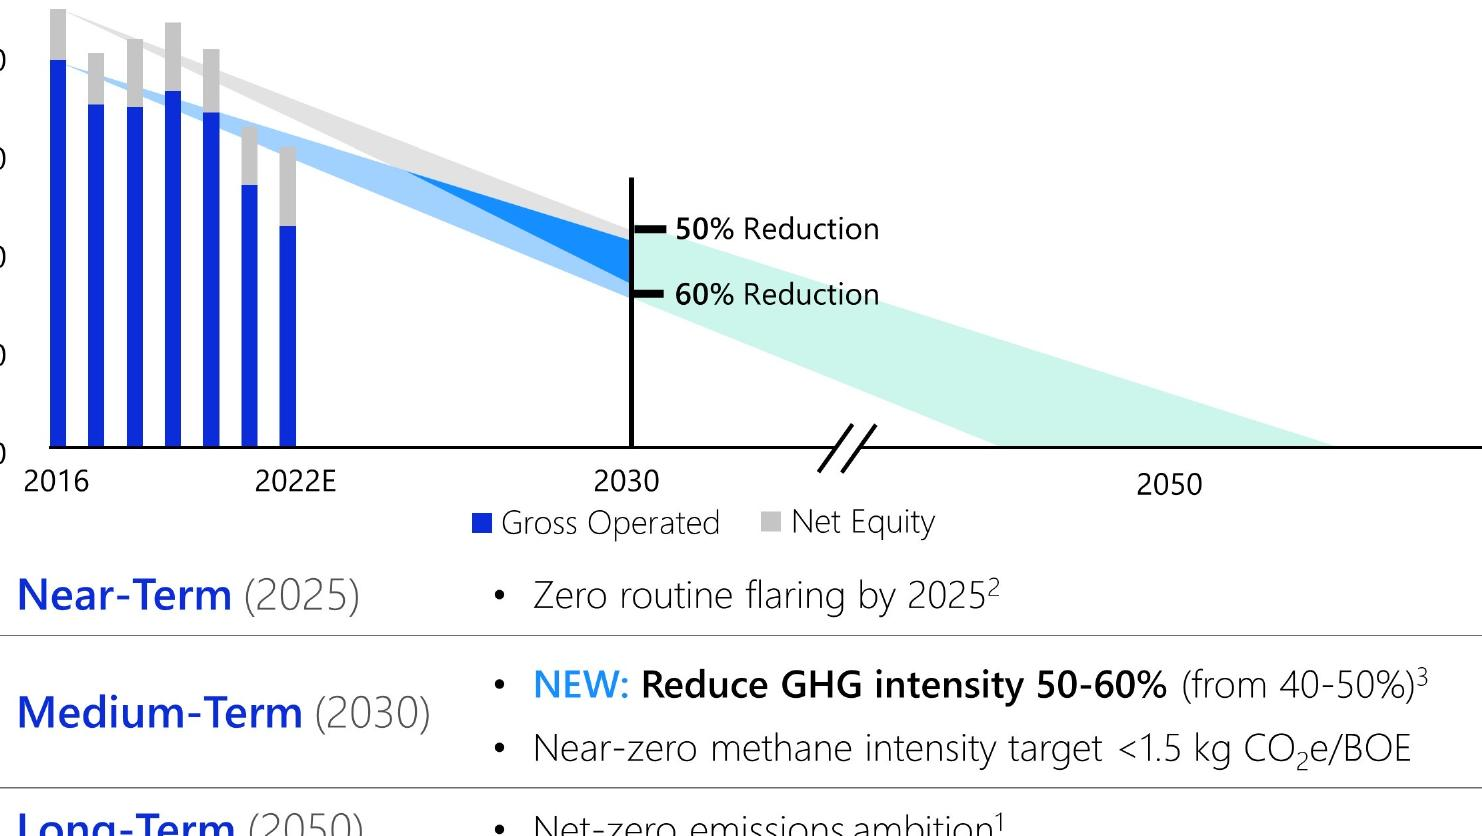
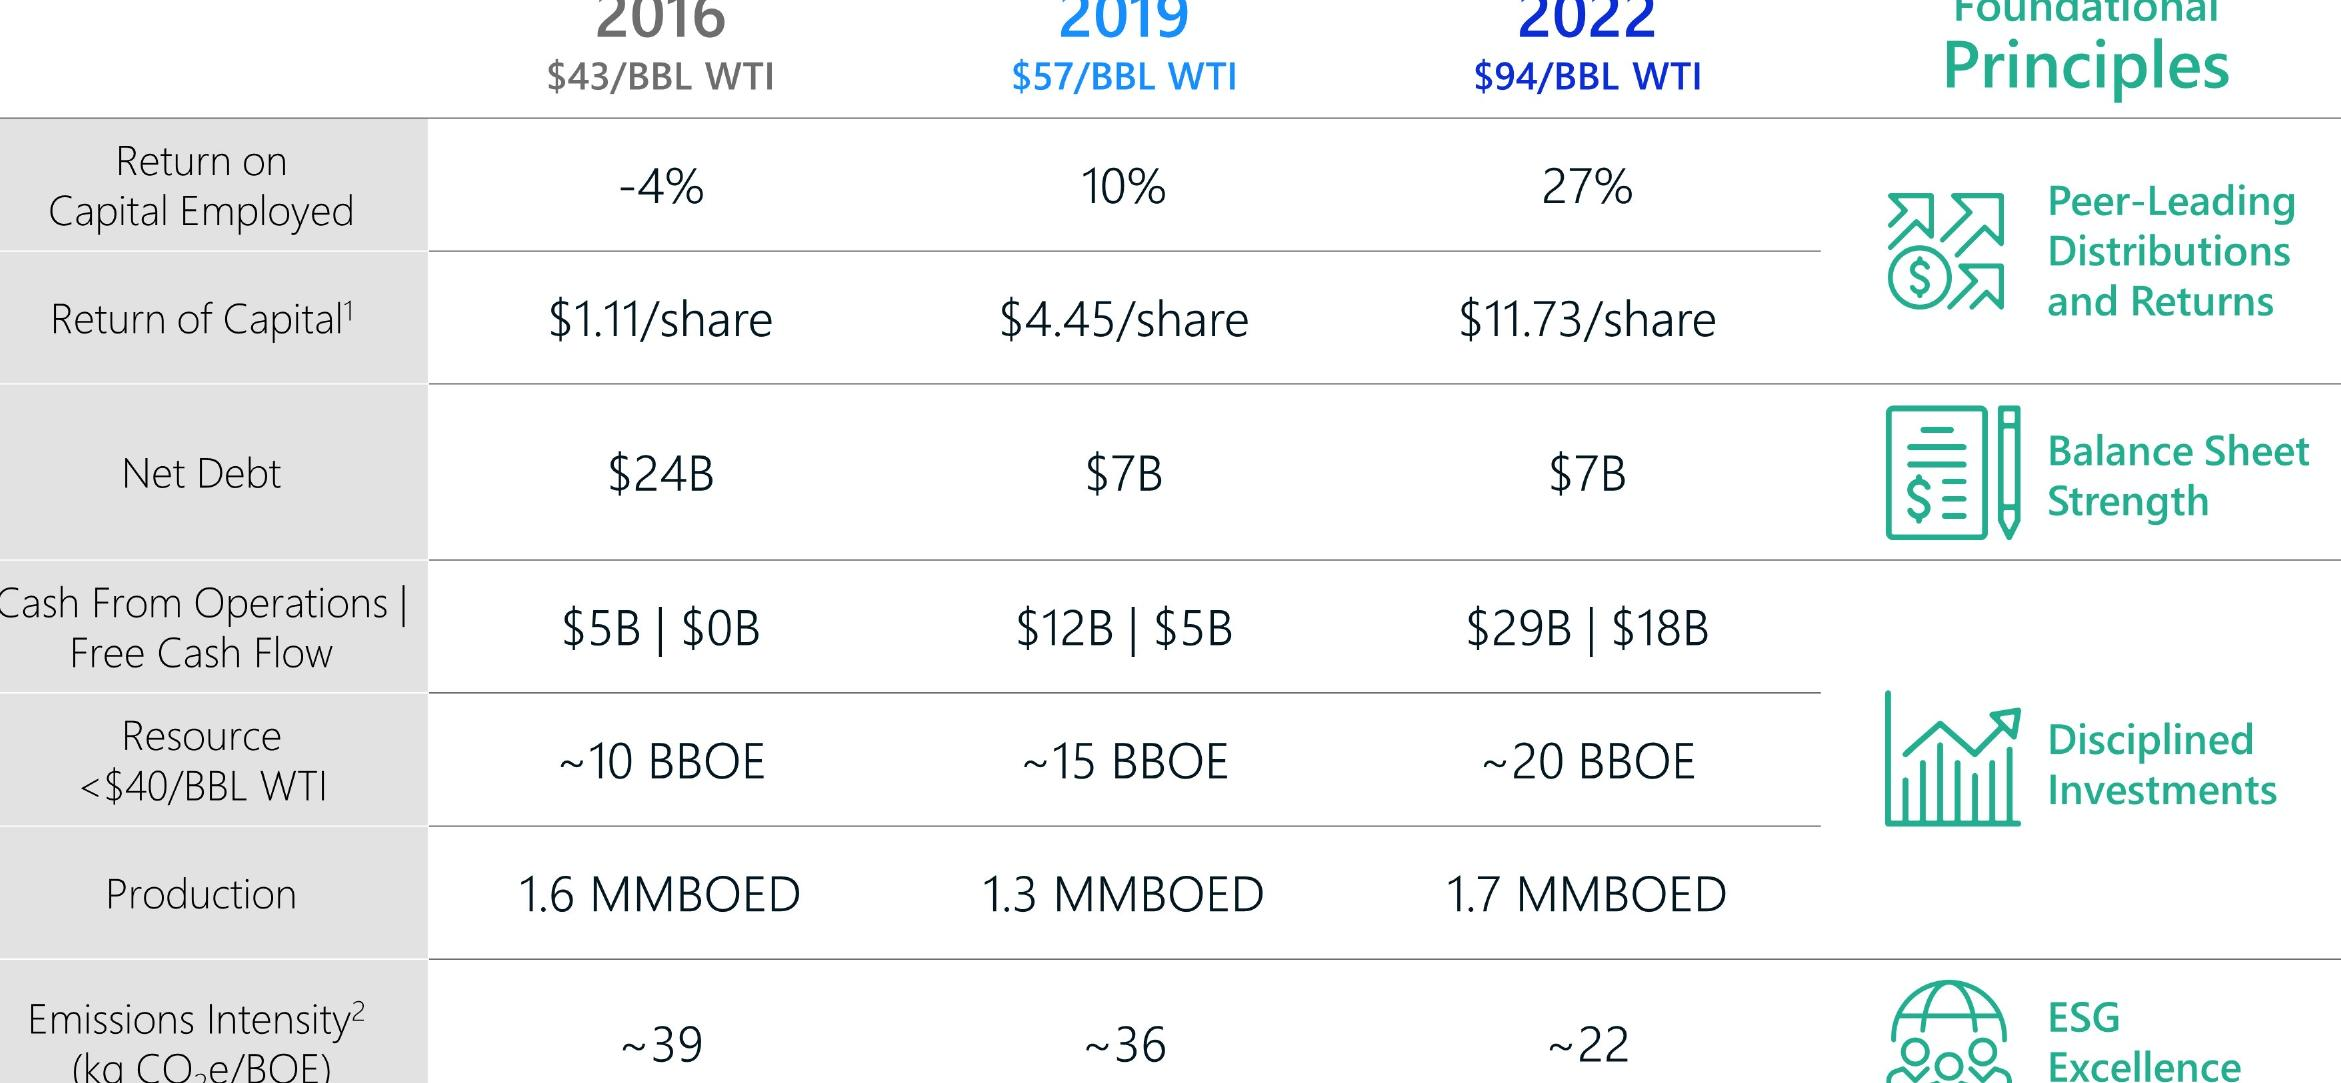
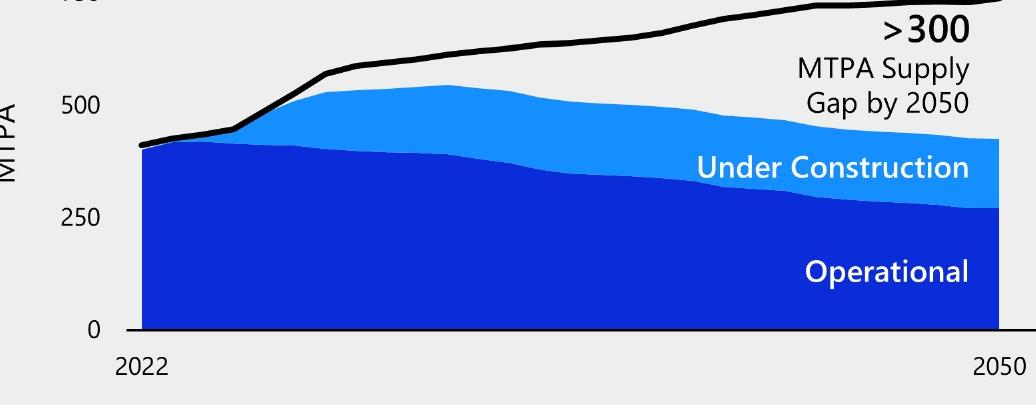
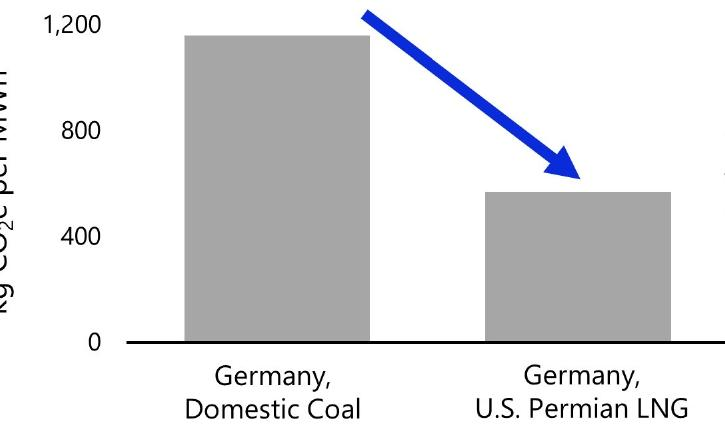

2025-02-11 18:46:04,827 - urllib3.connectionpool - DEBUG - https://api.smith.langchain.com:443 "POST /runs/multipart HTTP/1.1" 202 34
2025-02-11 18:47:22,141 - urllib3.connectionpool - DEBUG - https://api.smith.langchain.com:443 "POST /runs/multipart HTTP/1.1" 202 34
2025-02-11 18:47:27,260 - urllib3.connectionpool - DEBUG - https://api.smith.langchain.com:443 "POST /runs/multipart HTTP/1.1" 202 34
2025-02-11 18:47:28,161 - urllib3.connectionpool - DEBUG - https://api.smith.langchain.com:443 "POST /runs/multipart HTTP/1.1" 202 34
2025-02-11 18:47:29,102 - urllib3.connectionpool - DEBUG - https://api.smith.langchain.com:443 "POST /runs/multipart HTTP/1.1" 202 34
2025-02-11 18:47:30,127 - urllib3.connectionpool - DEBUG - https://api.smith.langchain.com:443 "POST /runs/multipart HTTP/1.1" 202 34
2025-02-11 18:47:31,866 - urllib3.connectionpool - DEBUG - https://api.smith.langchain.com:443 "POST /runs/multipart HTTP/1.1" 202 34
2025-02-11 18:47:34,018 - urllib3.connectionpool - DEBUG - htt

In [11]:
test_pdf_path = "backend/data/raw_pdfs/2023_removed.pdf"
model = ChatOpenAI(temperature=0, model="gpt-4o")

config_manager = ConfigurationManager(CONFIG_FILE_PATH, PARAMS_FILE_PATH)
data_ingestion_config = config_manager.get_data_ingestion_params()
image_summarizer_config = config_manager.get_image_summarizer_params()
text_summarizer_config = config_manager.get_text_summarizer_params()

data_ingestion = DataIngestion(data_ingestion_config)
image_summarizer = ImageSummarizer(image_summarizer_config, model)

raw_pdf_elements, report_dir = data_ingestion.process_pdf(test_pdf_path,
                                                          save=True,
                                    strategy="hi_res", # 
                                    split_pdf_page=True,  # to process each page seprately
                                    split_pdf_allow_failed=True, # continue processing even if some pages fail
                                    extract_images_in_pdf=True,
                                    infer_table_structure=True,
                                    chunking_strategy="by_title",
                                    extract_image_block_types = ["Image" , "Table"],
                                    max_characters=4000,
                                    new_after_n_chars=3800,
                                    combine_text_under_n_chars=2000)


image_path = "backend/data/reports/2023_removed/images"    
images_path = image_summarizer.get_image_path(image_path)
print(image_path)
encoded_images = []
image_summaries = []
meta_data = []

for image in images_path:
    encoded_image, image_source_path = image_summarizer.encode_image(image)
    image_summaries.append(image_summarizer.image_summarize(encoded_image))
    encoded_images.append(encoded_image)
    meta_data.append({"source": image_source_path,
                      "type": "image",
                      "title": image.split("/")[-1]})
    
image_summaries = image_summarizer.add_metadata(encoded_images, image_summaries, metadata=meta_data, automatic_metadata=False)

# # text summaries
text_summarizer = TextSummarizer(text_summarizer_config, model)
text_data = text_summarizer.get_text_data(raw_pdf_elements)

In [12]:
len(image_summaries), len(meta_data), len(encoded_images)

(10, 10, 10)

# vector store testing

In [7]:
from backend.src.storage.chroma_storage import VectorDatabase
from langchain_openai import OpenAIEmbeddings


vector_database_config = config_manager.get_vectordatabase_config()
vector_database = VectorDatabase(vector_database_config)
chroma = vector_database.init_chromadb(embeddings=OpenAIEmbeddings())
retriever = vector_database.get_multivector_retriever(chroma)
print(retriever)

2025-02-11 18:55:03,615 - chromadb.api.segment - DEBUG - Collection test5 already exists, returning existing collection.


vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x324e669a0> docstore=<langchain_core.stores.InMemoryStore object at 0x321f72fa0> search_kwargs={}


# Store text data


In [15]:
raw_text, text_summaries, summary_metadata = text_summarizer.generate_summary(text_data)

2025-02-11 18:47:21,084 - openai._base_client - DEBUG - Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'content': 'Act as an assistant tasked with summarizing the tables and text. Give a concise summary of the table or text. Table or text chunk: Cautionary Statement\n\nThis presentation provides management\'s current operational plan for ConocoPhillips over roughly the next decade, for the assets currently in our portfolio, and is subject to multiple assumptions, including, unless otherwise specifically noted: * anoil price of $60/BBL West Texas Intermediate in 2022 dollars, escalating at 2.25% annually;\n\n* anoil price of $65/BBL Brent in 2022 dollars, escalating at 2.25% annually;\n\n* agas price of $3.75/MMBTU Henry Hub in 2022 dollars, escalating at 2.25%\n\nannually;\n\nan international gas price of $8/MMBTU Title Transfer Facility & Japan Korea Marker in 2022 dollars, escalating at 2.25% annually;\n\n* cost and capital 

In [16]:
text_summaries = text_summarizer.add_metadata(raw_text, text_summaries, summary_metadata)

In [17]:
vector_database.store_to_vb(text_summaries, retriever)

2025-02-11 18:47:54,336 - openai._base_client - DEBUG - Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x3298a4ca0>, 'json_data': {'input': [[791, 14751, 1516, 661, 22504, 50729, 1221, 13441, 92777, 3153, 6, 25605, 3197, 369, 279, 1828, 13515, 11, 3196, 389, 1510, 12032, 323, 3892, 32946, 13, 5422, 32946, 2997, 5707, 323, 6962, 3430, 41579, 11, 449, 5707, 7729, 6041, 520, 400, 1399, 16675, 9574, 369, 4410, 8421, 61748, 323, 400, 2397, 16675, 9574, 369, 47431, 11, 323, 264, 6962, 3430, 315, 400, 18, 13, 2075, 38460, 18066, 52, 369, 18063, 27636, 11, 682, 77157, 520, 220, 17, 13, 914, 4, 30171, 13, 578, 3197, 1101, 32238, 6625, 6962, 7729, 323, 5764, 12782, 13426, 304, 8515, 6530, 51165, 1405, 8581, 13, 578, 5224, 66159, 430, 1521, 527, 4741, 31348, 41579, 3917, 311, 2349, 11, 11054, 555, 3230, 57726, 11, 323, 527, 28160, 555, 5370, 9547, 1778, 439, 2853, 71389, 323, 12782, 10396, 13], [791, 1495, 507

# Store Image data

In [18]:
vector_database.store_to_vb(image_summaries, retriever)

2025-02-11 18:48:01,978 - openai._base_client - DEBUG - Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x35ba74ee0>, 'json_data': {'input': [[791, 2217, 17610, 315, 1403, 1584, 40099, 27393, 18200, 9659, 8336, 323, 7432, 32907, 20748, 505, 220, 1049, 16, 311, 220, 2366, 16, 382, 334, 5530, 12441, 25, 74456, 24367, 12037, 1035, 12, 3146, 56, 6830, 7339, 68063, 64341, 4430, 315, 18200, 9659, 320, 15, 4, 311, 220, 1399, 4, 4390, 12, 3146, 55, 6830, 7339, 68063, 23116, 505, 220, 1049, 16, 311, 220, 2366, 16, 627, 12, 3146, 96773, 320, 14755, 7228, 1680, 334, 720, 220, 482, 48828, 520, 220, 3971, 4, 304, 220, 1049, 16, 627, 220, 482, 65201, 2315, 311, 220, 508, 4, 555, 220, 2366, 16, 627, 12, 3146, 59828, 320, 10544, 7228, 1680, 1035, 220, 482, 48828, 520, 220, 1114, 4, 304, 220, 1049, 16, 627, 220, 482, 68148, 311, 220, 1272, 4, 555, 220, 2366, 16, 382, 334, 6107, 12441, 25, 7432, 32907, 469, 5287, 1035

2025-02-11 18:48:01,981 - openai._base_client - DEBUG - Sending HTTP Request: POST https://api.openai.com/v1/embeddings
2025-02-11 18:48:01,983 - httpcore.connection - DEBUG - close.started
2025-02-11 18:48:01,984 - httpcore.connection - DEBUG - close.complete
2025-02-11 18:48:01,984 - httpcore.connection - DEBUG - connect_tcp.started host='api.openai.com' port=443 local_address=None timeout=None socket_options=None
2025-02-11 18:48:01,997 - httpcore.connection - DEBUG - connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x35ba69760>
2025-02-11 18:48:01,998 - httpcore.connection - DEBUG - start_tls.started ssl_context=<ssl.SSLContext object at 0x32d932ec0> server_hostname='api.openai.com' timeout=None
2025-02-11 18:48:02,015 - httpcore.connection - DEBUG - start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0x35b982910>
2025-02-11 18:48:02,015 - httpcore.http11 - DEBUG - send_request_headers.started request=<Request [b'POST']>
2025

In [7]:
from backend.src.storage.chroma_storage import VectorDatabase
from backend.src.config.configuration import ConfigurationManager

In [8]:
config_manager = ConfigurationManager(CONFIG_FILE_PATH, PARAMS_FILE_PATH)
vb_params = config_manager.get_vectordatabase_config()
print(vb_params)
vb = VectorDatabase(vb_params)
chroma = vb.init_chromadb(OpenAIEmbeddings())

retriever = vb.get_multivector_retriever(chroma, id_key="doc_id")


2025-02-11 18:55:15,379 - root - INFO - Yaml read successfully from config.yaml
2025-02-11 18:55:15,381 - root - INFO - Yaml read successfully from params.yaml
2025-02-11 18:55:15,381 - root - ERROR - Exception occured while reading yaml file from                         location: params.yaml
 First argument must be mapping or iterable
2025-02-11 18:55:15,452 - chromadb.api.segment - DEBUG - Collection test5 already exists, returning existing collection.


VectorDatabaseConfig(vectorstore_name='test5', persist_directory='vector_database/test_directory')


In [9]:
from backend.src.queries.handler import QueryHandler
qh = QueryHandler(retriever)
retriever = vb.get_vectorstore_as_retreiever(retriever.vectorstore)

In [10]:
retriever.invoke("what this report about")

2025-02-11 21:46:02,768 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): api.smith.langchain.com:443
2025-02-11 21:46:03,192 - urllib3.connectionpool - DEBUG - https://api.smith.langchain.com:443 "GET /info HTTP/1.1" 200 672
2025-02-11 21:46:03,199 - openai._base_client - DEBUG - Request options: {'method': 'post', 'url': '/embeddings', 'files': None, 'post_parser': <function Embeddings.create.<locals>.parser at 0x324ec55e0>, 'json_data': {'input': [[12840, 420, 1934, 922]], 'model': 'text-embedding-ada-002', 'encoding_format': 'base64'}}
2025-02-11 21:46:03,203 - openai._base_client - DEBUG - Sending HTTP Request: POST https://api.openai.com/v1/embeddings
2025-02-11 21:46:03,204 - httpcore.connection - DEBUG - connect_tcp.started host='api.openai.com' port=443 local_address=None timeout=None socket_options=None
2025-02-11 21:46:03,279 - httpcore.connection - DEBUG - connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x324e91af0>
2025-0

[Document(id='461377be-4f79-4ad1-899d-ab216fcaf38e', metadata={'doc_id': 'd4b31a12-4106-4d6b-813a-d08f6c88bf66', 'file_directory': 'backend/data/raw_pdfs', 'filename': '2023_removed.pdf', 'filetype': 'application/pdf', 'languages': 'eng', 'last_modified': '2025-02-06T12:34:29', 'orig_elements': 'eJy1WFFvHLcR/ivEvTQBTqokW4rsezKctMhDGyN2nAfDEHhc7i4rLrkhuXc6B/nv+WZI7u1JahoU7YNhLY/kzHwz880MP/260lYP2qU706xei5W8vLzV6vry7Oby9puzl83L67PbGynPtlrdvmyu2ra9vV6txWrQSTYySZz5daW8D41xMunI31Ye/JTuem26PmHl8vriAmfK8t40qcfq1c3NN1gdvXGJzn36dHN7/nItrm8vzi8+r0X5vLy8uTm/pe+rm4sX56+eW8lHsLKKh5j0QJa8Mw/avh+l0qvf8EOjk1bJeHenrIzxbgx+i20X56+ury5usaE1VqfDqPnsu3+sWGHXTbJjqz6ttOtWn3k1prvBN6Y1mjG7uri6Pru4Oru4+XB59frFy9dXr+j0iJN3bhq2OhAGpETSD4TH6udeB70WxgnpDqL1YS9Dc2a9vzeuEzEBSfLJWqReC+WHkbbphzHoGHXEIfqAOZIMEj6IrbZGt0JGkbxopzQFLbB5simuRZxU/28OmCi2MupGYHWQDhqT3L9E0XnfiFaa1IsRMJBMbNr+izDcQYXJNTqwegBzGka6N4qoE1mDQ3Lrd1p8NTkLlYXziWRge9ibqL/m21iFHdah8pbUldE7ubV0pfCteDMGY8Xl1VoA4BcZC4Scpt9SD80JDmjLNp2LDz2+jthBY2AAwQIuDNIlrfn

2025-02-11 21:46:04,472 - urllib3.connectionpool - DEBUG - Resetting dropped connection: us.i.posthog.com
2025-02-11 21:46:05,324 - urllib3.connectionpool - DEBUG - https://api.smith.langchain.com:443 "POST /runs/multipart HTTP/1.1" 202 34
2025-02-11 21:46:05,836 - urllib3.connectionpool - DEBUG - https://us.i.posthog.com:443 "POST /batch/ HTTP/1.1" 200 15
